In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

import os
import datetime
import itertools


def printTime(tag):
    """
    ログ出力用の関数
    """
    print(tag + ':', datetime.datetime.now())


printTime('Inputファイルを表示')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Inputファイルを表示: 2020-03-23 10:57:11.362833
/kaggle/input/data_description_ja.md
/kaggle/input/test.csv
/kaggle/input/data_description.txt
/kaggle/input/train.csv
/kaggle/input/.ipynb_checkpoints/train-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/test-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/data_description-checkpoint.txt


#### 学習データの読み込み

In [16]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['Id', 'SalePrice'], axis=1)
train_y = train['SalePrice']

# テストデータは特徴量のみなので、そのままでよい
test_x = test.drop(['Id'], axis=1)
test_id = test['Id']

 #### 特徴量作成

In [17]:
# 解析対象とする数値列を設定
targets_num = ['1stFlrSF',
               '2ndFlrSF',
               'BsmtFinSF1',
               'Fireplaces',
               'FullBath',
               'GarageArea',
               'GarageCars',
               'GarageYrBlt',
               'GrLivArea',
               'MasVnrArea',
               'OverallQual',
               'OverallCond',
               'TotalBsmtSF',
               'TotRmsAbvGrd',
               'YearBuilt',
               'YearRemodAdd']

# 解析対象とするカテゴリ列を設定
targets_category = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    # 'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    # 'BsmtQual',
    # 'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    # 'KitchenQual',
    'Functional',
    # 'FireplaceQu',
    'GarageType',
    'GarageFinish',
    # 'GarageQual',
    'GarageCond',
    'PavedDrive',
    # 'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition']

# 解析対象とする数値列とカテゴリ列の列名を連結
targets = targets_num
targets.extend(targets_category)

# Dataframeの列の型がobjectのままだとLabelEncoderでエラーするため、strに変換
# ※変換処理後にinfo()で型を確認しても、objectと表示されるが内部的にはstrに変換されている。
train_x[targets_category] = train_x[targets_category].astype(str)
test_x[targets_category] = test_x[targets_category].astype(str)

In [18]:

def addTotalGrSF(df):
    
    dv_ary = []
    for index, row in df.iterrows():

        dv_ary.append(row['1stFlrSF'] + row['2ndFlrSF'])

    # Seriesに変換
    dv = pd.Series(dv_ary).astype(float)
    # DataFrameと結合
    df['TotalGrSF'] = dv


addTotalGrSF(train_x)
addTotalGrSF(test_x)

In [19]:

def setAstype(train, test, colName, setType):

    train[colName] = train[colName].astype(setType)
    test[colName] = test[colName].astype(setType)


dec = {
    'LotShape': {
        'Reg': 4,
        'IR1': 3,
        'IR2': 2,
        'IR3': 1
    },
    'BsmtCond': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'BsmtQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'FireplaceQu': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'KitchenQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'PoolQC': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'GarageQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
}

train_x.replace(dec, inplace=True)
test_x.replace(dec, inplace=True)

# 型を設定（後の計算でのエラー回避のため）
setAstype(train_x, test_x, 'LotShape', 'float')
setAstype(train_x, test_x, 'BsmtCond', 'float')
setAstype(train_x, test_x, 'BsmtQual', 'float')
setAstype(train_x, test_x, 'FireplaceQu', 'float')
setAstype(train_x, test_x, 'KitchenQual', 'float')
setAstype(train_x, test_x, 'PoolQC', 'float')
setAstype(train_x, test_x, 'GarageQual', 'float')

In [20]:

# ラベルエンコーディング用に学習データとテストデータをunion
lavel_x = train_x.append(test_x, ignore_index=True)

# カテゴリ変数をlabel encodingする
for c in targets_category:
    # 学習データとテストデータに基づいてラベルを設定
    le = LabelEncoder()
    le.fit(lavel_x[c])
    train_x[c] = le.transform(train_x[c])
    test_x[c] = le.transform(test_x[c])

#### モデル作成とバリデーション
LightGBMを使用してモデルを作成します。

モデルの作成開始: 2020-03-23 10:57:12.025492
RMSE: 0.1385
RMSE: 0.1353
RMSE: 0.1573
RMSE: 0.1126
モデルの作成終了: 2020-03-23 10:57:14.354184


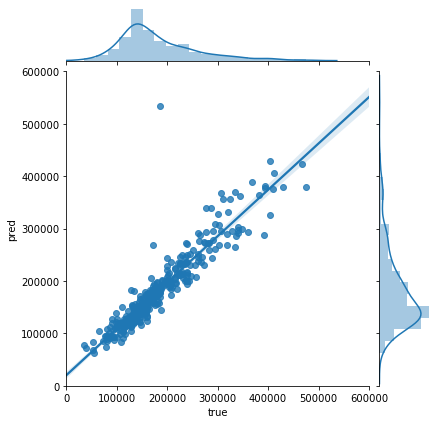

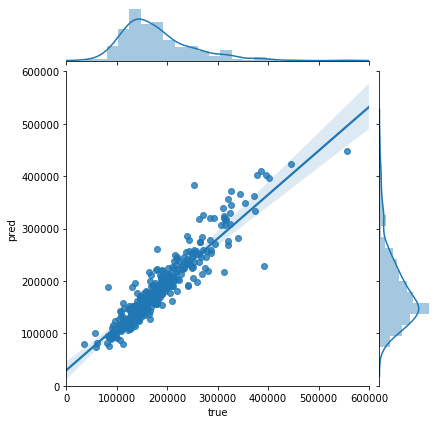

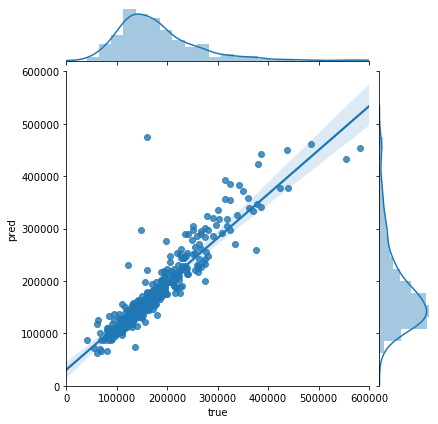

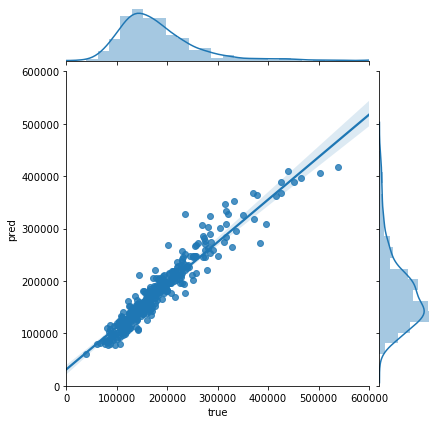

In [21]:
printTime('モデルの作成開始')

va_pred_list = []
pred_list = []

# 学習データを学習データとバリデーションデータに分ける
kf = KFold(n_splits=4, shuffle=True, random_state=71)

for tr_idx, va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # 特徴量と目的変数をlightgbmのデータ構造に変換する
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)

    # ハイパーパラメータの設定
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression_l2',
        'metric': 'l2',
        'num_leaves': 40,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l2': 2,
    }

    # 作成する決定木の数を指定
    num_round = 100

    # 学習の実行
    # カテゴリ変数をパラメータで指定している
    # バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=num_round,
                      # categorical_feature=targets_category,
                      valid_names=['train', 'valid'],
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=0)

    # バリデーションデータでのスコアの確認
    va_pred = model.predict(va_x)
    va_pred_list.append(va_pred)

    # バリデーションデータでのスコア(真の値の対数と予測値の対数の二乗平均平方根誤差 (RMSE))を計算する
    rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))

    print(f'RMSE: {rmse:.4f}')

    # 結果の可視化
    sns.jointplot(
        va_y,
        va_pred,
        kind="reg",
        xlim=(0, 600000),
        ylim=(0, 600000)
    ).set_axis_labels("true", "pred")

    # 予測
    pred_list.append(model.predict(test_x))


va_pred_list = np.array(va_pred_list)
pred_list = np.array(pred_list)

# 提出用ファイルの作成
submission = pd.DataFrame({'Id': test_id, 'SalePrice': np.mean(pred_list, axis=0)})
submission.to_csv('/kaggle/output/submission_ensemble.csv', index=False)

printTime('モデルの作成終了')

#### データの分析にどの特徴量が重要だったのかをプロット

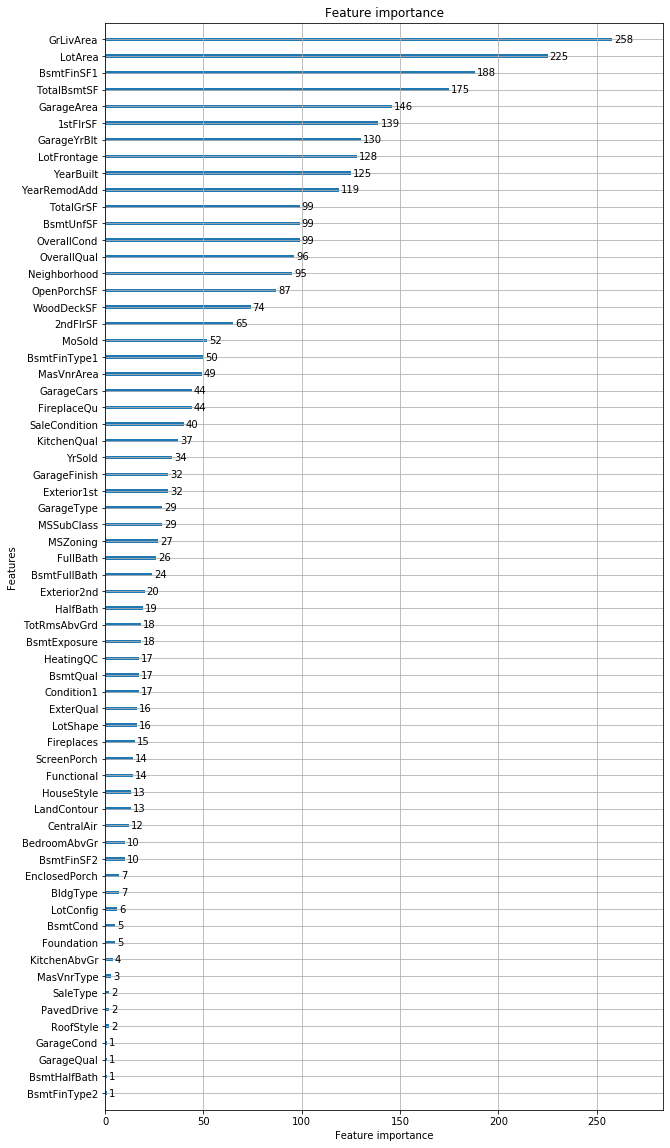

In [22]:
lgb.plot_importance(model, figsize=(10, 20))

#### 分析に使用した決定木を可視化

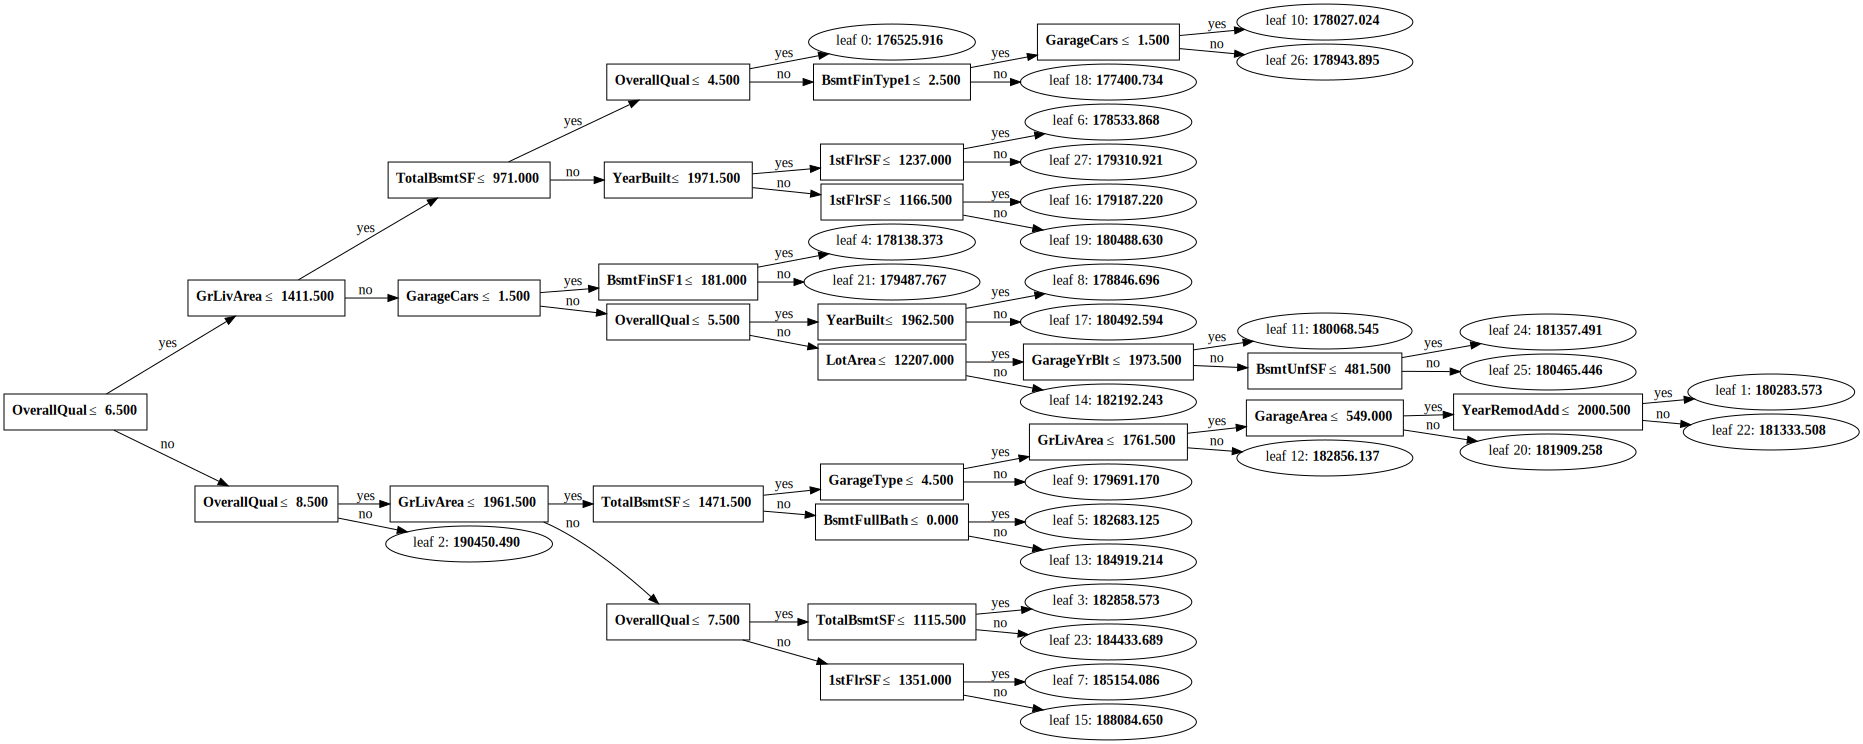

In [23]:
lgb.create_tree_digraph(model)